In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


In [15]:
# Load existing RFM DataFrame
rfm = pd.read_csv("rfm.csv")  

# Preview
rfm.head()


,CustomerID,recency,frequency,monetary,year
0,AA-10315,185,1,374.480,2017
1,AA-10375,20,2,206.732,2017
2,AA-10480,260,1,15.552,2017
3,AA-10645,56,1,12.960,2017
4,AB-10060,55,4,2936.264,2017


In [17]:
rfm_log = rfm.copy()
rfm_log[['recency', 'frequency', 'monetary']] = rfm_log[['recency', 'frequency', 'monetary']].apply(np.log1p)

## Identifying outliers

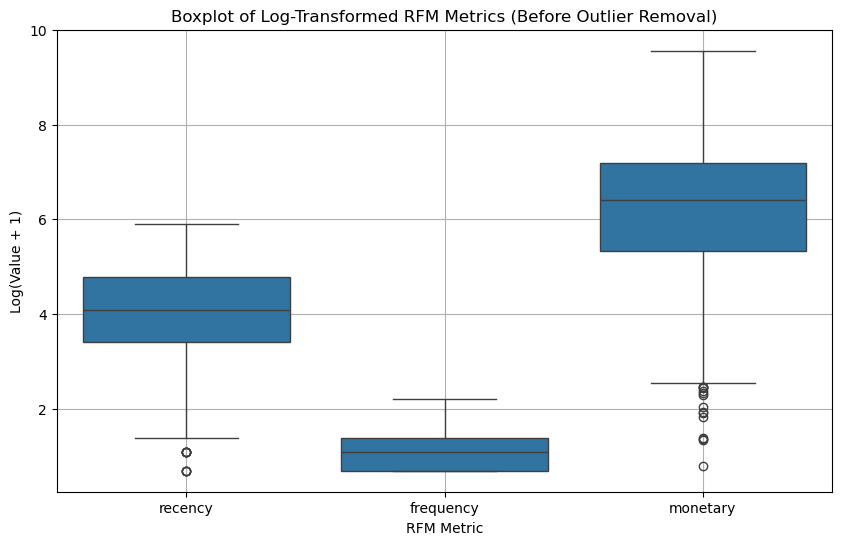

In [19]:
rfm_melted_log = rfm_log.melt(id_vars='CustomerID',
                              value_vars=['recency', 'frequency', 'monetary'],
                              var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=rfm_melted_log)
plt.title('Boxplot of Log-Transformed RFM Metrics (Before Outlier Removal)')
plt.xlabel('RFM Metric')
plt.ylabel('Log(Value + 1)')
plt.grid(True)
plt.show()

## Outlier Removal using IQR Method

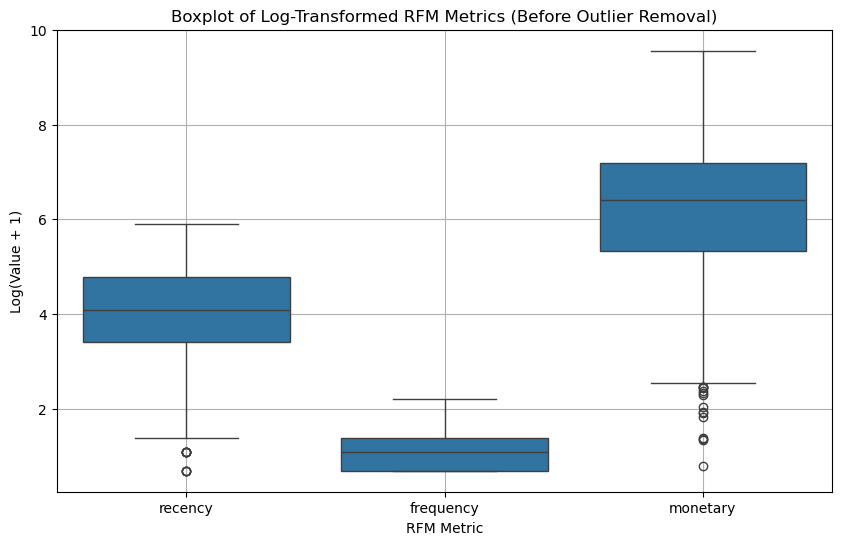

In [20]:
rfm_melted_log = rfm_log.melt(id_vars='CustomerID',
                              value_vars=['recency', 'frequency', 'monetary'],
                              var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=rfm_melted_log)
plt.title('Boxplot of Log-Transformed RFM Metrics (Before Outlier Removal)')
plt.xlabel('RFM Metric')
plt.ylabel('Log(Value + 1)')
plt.grid(True)
plt.show()

In [21]:
rfm_log_clean = remove_outliers_iqr(rfm_log, ['recency', 'frequency', 'monetary'])

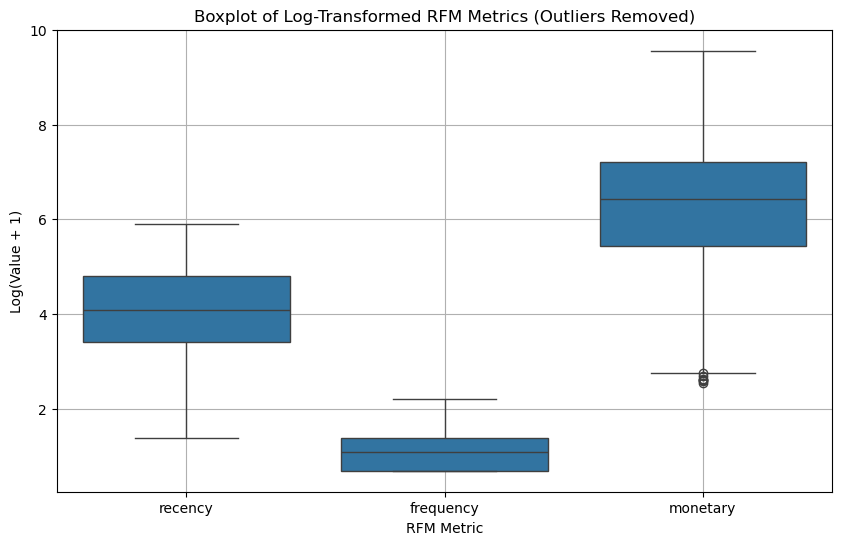

In [22]:
rfm_melted_log_clean = rfm_log_clean.melt(id_vars='CustomerID',
                                          value_vars=['recency', 'frequency', 'monetary'],
                                          var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=rfm_melted_log_clean)
plt.title('Boxplot of Log-Transformed RFM Metrics (Outliers Removed)')
plt.xlabel('RFM Metric')
plt.ylabel('Log(Value + 1)')
plt.grid(True)
plt.show()

In [23]:
print(f"Original RFM shape: {rfm_log.shape}")
print(f"After outlier removal: {rfm_log_clean.shape}")

Original RFM shape: (693, 5)
After outlier removal: (669, 5)


## Standardize the Data

In [24]:
from sklearn.preprocessing import StandardScaler

# ----------------------------------
# 1. Prepare data (already log-transformed and outliers removed)
# ----------------------------------
rfm_features = rfm_log_clean[['recency', 'frequency', 'monetary']].copy()

# ----------------------------------
# 2. Initialize and apply StandardScaler
# ----------------------------------
scaler = StandardScaler()
rfm_scaled_array = scaler.fit_transform(rfm_features)

# Convert back to a DataFrame to retain column names and indices
rfm_scaled = pd.DataFrame(rfm_scaled_array, columns=['recency', 'frequency', 'monetary'], index=rfm_log_clean.index)

# Optionally add back CustomerID if needed for reference
rfm_scaled['CustomerID'] = rfm_log_clean['CustomerID'].values

# ----------------------------------
# 3. Inspect result
# ----------------------------------
print(rfm_scaled.head())


    recency  frequency  monetary CustomerID
0  1.152706  -1.304869 -0.204361   AA-10315
1 -1.005307  -0.201101 -0.626909   AA-10375
2  1.487875  -1.304869 -2.432677   AA-10480
3 -0.017404  -1.304869 -2.554247   AA-10645
4 -0.034915   1.189481  1.263977   AB-10060


## Build the model

In [25]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

In [27]:
# Fit kmeans again using only numeric columns (excluding CustomerID)
kmeans.fit(rfm_scaled[['recency', 'frequency', 'monetary']])

KMeans(max_iter=50, n_clusters=4)

In [28]:
from collections import Counter
# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 124), (1, 172), (2, 147), (3, 226)]

## Finding the optimal number of clusters

### The Elbow Method

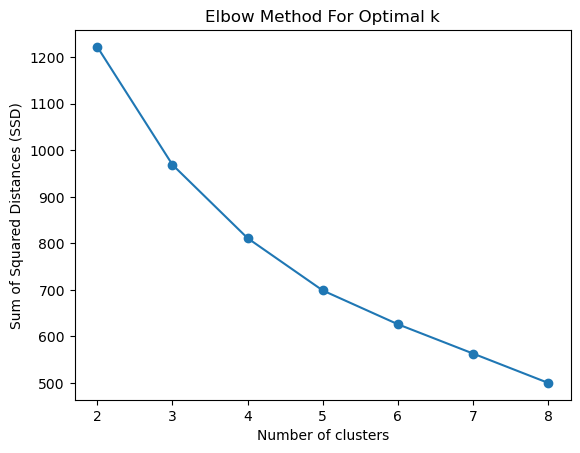

In [36]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled[['recency', 'frequency', 'monetary']])

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(range_n_clusters, ssd, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.show()

### Silhouette Analysis

In [37]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled[['recency', 'frequency', 'monetary']])

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_scaled[['recency', 'frequency', 'monetary']], cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.33145589225295347
For n_clusters=3, the silhouette score is 0.2743967175018814
For n_clusters=4, the silhouette score is 0.27841071930838895
For n_clusters=5, the silhouette score is 0.2505182549469508
For n_clusters=6, the silhouette score is 0.25951079423075707
For n_clusters=7, the silhouette score is 0.28137661439743805
For n_clusters=8, the silhouette score is 0.2543600047538073


In [39]:
# Calculate silhouette scores for each number of clusters and display as a table
silhouette_scores = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    labels = kmeans.fit_predict(rfm_scaled[['recency', 'frequency', 'monetary']])
    score = silhouette_score(rfm_scaled[['recency', 'frequency', 'monetary']], labels)
    silhouette_scores.append({'n_clusters': num_clusters, 'silhouette_score': score})

# Convert to DataFrame for display
silhouette_df = pd.DataFrame(silhouette_scores)
silhouette_df

,n_clusters,silhouette_score
0,2,0.331086
1,3,0.275254
2,4,0.277678
3,5,0.259421
4,6,0.263531
5,7,0.281682
6,8,0.255199


In [42]:
k_clusters = 4 # increment to compare different cluster #s
kmeans = KMeans(n_clusters=k_clusters, random_state=420)
# Use only numeric columns for clustering and silhouette score
numeric_cols = ['recency', 'frequency', 'monetary']
silhouette_avg = silhouette_score(rfm_scaled[numeric_cols], kmeans.fit_predict(rfm_scaled[numeric_cols]))
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.27841071930838895
